# Prophet on Average Sales (Units Sold) with Explanatory Variables

In [ ]:
import pandas as pd
from prophet import Prophet
import numpy as np
import matplotlib.pyplot as plt
import logging
import itertools
%matplotlib inline

In [8]:
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

In [9]:
def calculate_smape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    numerator = np.abs(y_true - y_pred)
    denominator = np.abs(y_true) + np.abs(y_pred)
    
    smape = 100 * np.mean(numerator / (denominator + 1e-10 ))
    return smape

In [10]:
df = pd.read_csv('../dataset/clustered_data.csv')

In [12]:
total_df = df.groupby('Date')[['UnitsSold', 'AveragePricePerUnitPounds']].mean().reset_index()
total_df = total_df.rename(columns={'Date': 'date', 'UnitsSold': "y"})

In [13]:
explanatory_df = pd.read_csv('../explanatory_variables/combined_explanatory_variables.csv')

In [14]:
total_df = total_df.merge(explanatory_df, on='date', how='left')

In [15]:
total_df = total_df.rename(columns={'date': 'ds'})
total_df['ds'] = pd.to_datetime(total_df['ds'])

In [16]:
regressors = ['AveragePricePerUnitPounds', 'gift_ideas',
       'chained-volume-percentage-change-3-months-on-same-period-a-year-earlier',
       'chained-volume-percentage-change-on-previous-month',
       'chained-volume-percentage-change-on-same-month-a-year-earlier',
       'current-prices-percentage-change-on-previous-month',
       'current-prices-percentage-change-on-same-month-a-year-earlier',
       'is_black_friday', 'is_cyber_monday', 'cpi', 'cci', 'interest_rate',
       'unemployment_rate', 'is_holiday', 'is_Friday', 'is_Monday',
       'is_Saturday', 'is_Sunday', 'is_Thursday', 'is_Tuesday',
       'is_Wednesday']

In [17]:
n = len(total_df)
train_end = int(n * 0.6)
val_end = int(n * 0.8)

train_data = total_df.iloc[:train_end]
validation_data = total_df.iloc[train_end:val_end]
test_data = total_df.iloc[val_end:]

In [18]:
clip_threshold = np.percentile(total_df['y'], 99)

In [19]:
model = Prophet()

for reg in regressors:
    model.add_regressor(reg)
    
model.fit(train_data)

20:51:56 - cmdstanpy - INFO - Chain [1] start processing
20:51:56 - cmdstanpy - INFO - Chain [1] done processing


## Validation

In [20]:
validation_forecast = model.predict(validation_data)

In [21]:
actual_values = np.array(validation_data['y'])
predicted_values = np.array(validation_forecast['yhat'])

In [22]:
validation_smape = calculate_smape(actual_values, predicted_values)
validation_smape

40.54721029874471

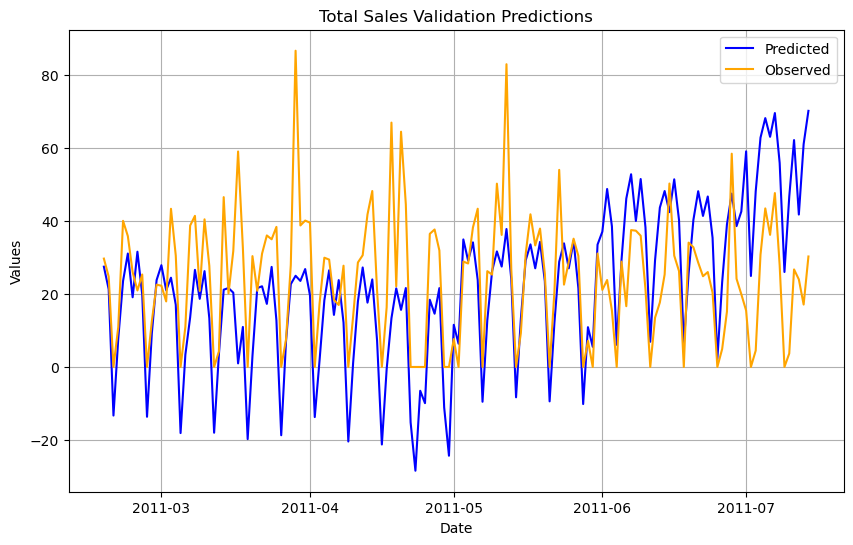

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(pd.to_datetime(validation_data['ds']), validation_forecast['yhat'], label='Predicted', color='blue')
plt.plot(pd.to_datetime(validation_data['ds']), validation_data['y'], label='Observed', color='orange')
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Total Sales Validation Predictions')
plt.legend()
plt.grid(True)
plt.show()

## Test

In [24]:
test_forecast = model.predict(test_data)

In [25]:
actual_values = np.array(test_data['y'])
predicted_values = np.array(test_forecast['yhat'])

In [26]:
test_smape = calculate_smape(actual_values, predicted_values)
test_smape

54.40437123191727

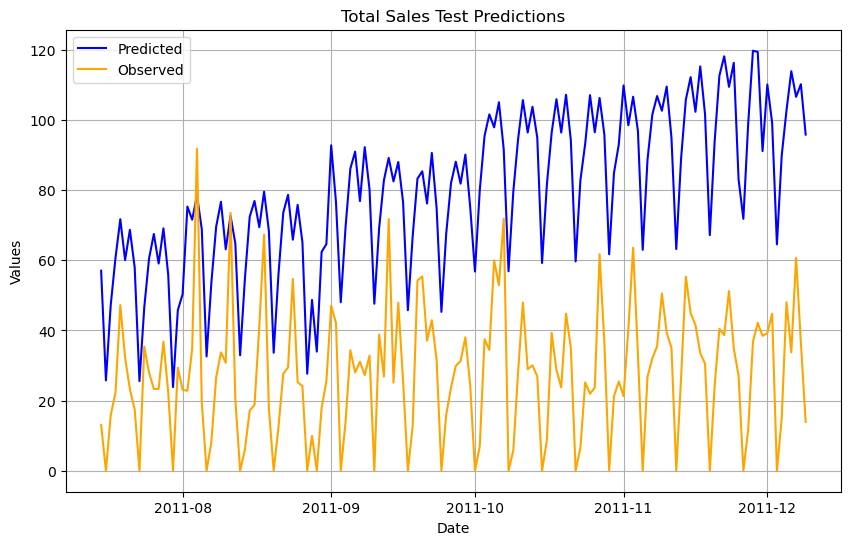

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(pd.to_datetime(test_data['ds']), test_forecast['yhat'], label='Predicted', color='blue')
plt.plot(pd.to_datetime(test_data['ds']), test_data['y'], label='Observed', color='orange')
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Total Sales Test Predictions')
plt.legend()
plt.grid(True)
plt.show()

## Overall

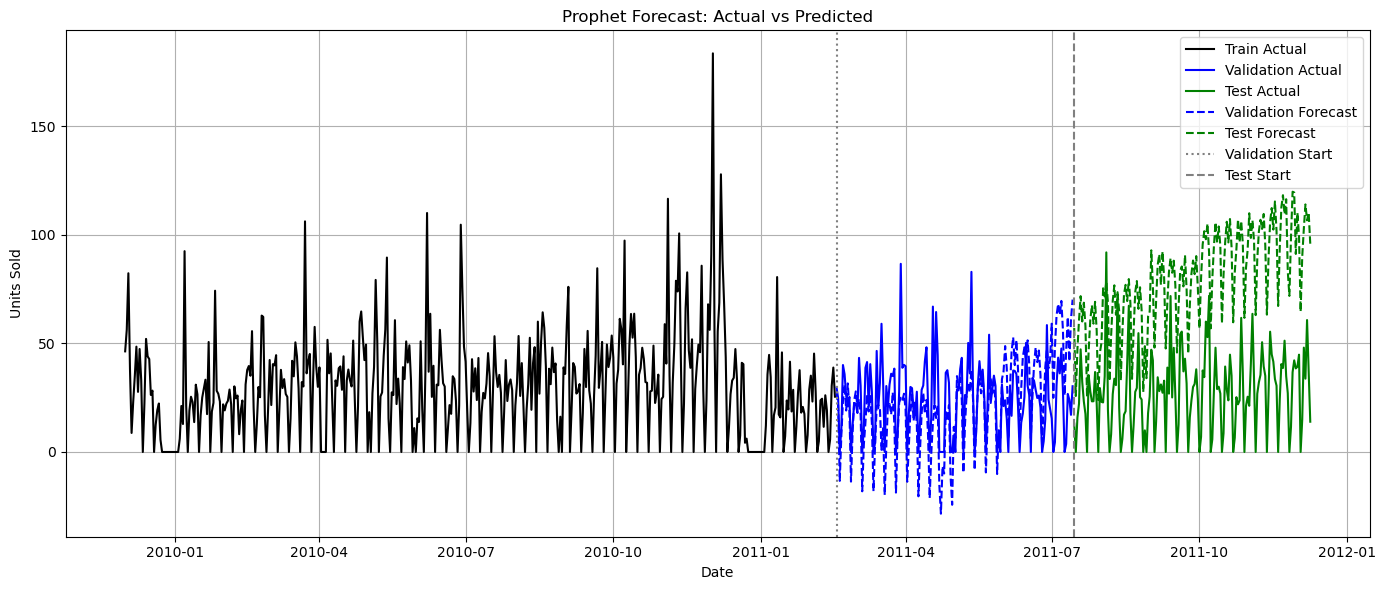

In [28]:
plt.figure(figsize=(14, 6))

plt.plot(train_data['ds'], train_data['y'], label='Train Actual', color='black')
plt.plot(validation_data['ds'], validation_data['y'], label='Validation Actual', color='blue')
plt.plot(test_data['ds'], test_data['y'], label='Test Actual', color='green')

plt.plot(validation_forecast['ds'], validation_forecast['yhat'], label='Validation Forecast', color='blue', linestyle='--')
plt.plot(test_forecast['ds'], test_forecast['yhat'], label='Test Forecast', color='green', linestyle='--')

plt.axvline(x=validation_data['ds'].min(), color='gray', linestyle=':', label='Validation Start')
plt.axvline(x=test_data['ds'].min(), color='gray', linestyle='--', label='Test Start')

plt.title('Prophet Forecast: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Tuning

In [29]:
param_grid = {
    "changepoint_prior_scale": [0.01, 0.05, 0.1, 0.2, 0.5],
    "seasonality_prior_scale": [0.05, 0.1, 0.5, 1, 5],
    "fourier_order": [3, 5, 10]
}

best_smape = float("inf")
best_params = None
best_model = None

In [30]:
train_data = train_data.replace([np.inf, -np.inf], np.nan).dropna()
validation_data = validation_data.replace([np.inf, -np.inf], np.nan).dropna()
test_data = test_data.replace([np.inf, -np.inf], np.nan).dropna()

In [31]:
# Grid search loop
for cps, sps, fo in itertools.product(
    param_grid["changepoint_prior_scale"],
    param_grid["seasonality_prior_scale"],
    param_grid["fourier_order"]
):
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        changepoint_prior_scale=cps,
        seasonality_prior_scale=sps
    )

    # Add custom monthly seasonality
    model.add_seasonality(name="monthly", period=30.5, fourier_order=fo)

    for reg in regressors:
        model.add_regressor(reg)

    try:
        # Fit model
        model.fit(train_data)

        # Predict on test
        future = validation_data[['ds'] + regressors]
        forecast = model.predict(future)

        # Evaluate
        y_true = validation_data["y"]
        y_pred = np.clip(forecast["yhat"], 0, clip_threshold)

        smape = calculate_smape(y_true, y_pred)

        print(f"cps={cps}, sps={sps}, fo={fo}: SMAPE={smape:.2f}%")

        if smape < best_smape:
            best_smape = smape
            best_params = (cps, sps, fo)
            best_model = model

    except Exception as e:
        print(f"⚠️ Skipping params (cps={cps}, sps={sps}, fo={fo}) due to error: {e}")

20:51:59 - cmdstanpy - INFO - Chain [1] start processing
20:51:59 - cmdstanpy - INFO - Chain [1] done processing
20:52:00 - cmdstanpy - INFO - Chain [1] start processing


cps=0.01, sps=0.05, fo=3: SMAPE=36.34%


20:52:00 - cmdstanpy - INFO - Chain [1] done processing


cps=0.01, sps=0.05, fo=5: SMAPE=35.88%


20:52:00 - cmdstanpy - INFO - Chain [1] start processing
20:52:00 - cmdstanpy - INFO - Chain [1] done processing
20:52:01 - cmdstanpy - INFO - Chain [1] start processing


cps=0.01, sps=0.05, fo=10: SMAPE=37.44%


20:52:01 - cmdstanpy - INFO - Chain [1] done processing


cps=0.01, sps=0.1, fo=3: SMAPE=38.03%


20:52:01 - cmdstanpy - INFO - Chain [1] start processing
20:52:01 - cmdstanpy - INFO - Chain [1] done processing
20:52:02 - cmdstanpy - INFO - Chain [1] start processing


cps=0.01, sps=0.1, fo=5: SMAPE=34.98%


20:52:02 - cmdstanpy - INFO - Chain [1] done processing
20:52:02 - cmdstanpy - INFO - Chain [1] start processing


cps=0.01, sps=0.1, fo=10: SMAPE=36.97%


20:52:02 - cmdstanpy - INFO - Chain [1] done processing


cps=0.01, sps=0.5, fo=3: SMAPE=38.80%


20:52:03 - cmdstanpy - INFO - Chain [1] start processing
20:52:03 - cmdstanpy - INFO - Chain [1] done processing
20:52:03 - cmdstanpy - INFO - Chain [1] start processing


cps=0.01, sps=0.5, fo=5: SMAPE=38.67%


20:52:03 - cmdstanpy - INFO - Chain [1] done processing
20:52:04 - cmdstanpy - INFO - Chain [1] start processing


cps=0.01, sps=0.5, fo=10: SMAPE=36.04%


20:52:04 - cmdstanpy - INFO - Chain [1] done processing


cps=0.01, sps=1, fo=3: SMAPE=37.66%


20:52:04 - cmdstanpy - INFO - Chain [1] start processing
20:52:04 - cmdstanpy - INFO - Chain [1] done processing


cps=0.01, sps=1, fo=5: SMAPE=38.14%


20:52:05 - cmdstanpy - INFO - Chain [1] start processing
20:52:05 - cmdstanpy - INFO - Chain [1] done processing
20:52:05 - cmdstanpy - INFO - Chain [1] start processing


cps=0.01, sps=1, fo=10: SMAPE=39.76%


20:52:05 - cmdstanpy - INFO - Chain [1] done processing
20:52:06 - cmdstanpy - INFO - Chain [1] start processing


cps=0.01, sps=5, fo=3: SMAPE=37.26%


20:52:06 - cmdstanpy - INFO - Chain [1] done processing


cps=0.01, sps=5, fo=5: SMAPE=36.58%


20:52:06 - cmdstanpy - INFO - Chain [1] start processing
20:52:07 - cmdstanpy - INFO - Chain [1] done processing


cps=0.01, sps=5, fo=10: SMAPE=35.22%


20:52:07 - cmdstanpy - INFO - Chain [1] start processing
20:52:07 - cmdstanpy - INFO - Chain [1] done processing


cps=0.05, sps=0.05, fo=3: SMAPE=33.52%


20:52:08 - cmdstanpy - INFO - Chain [1] start processing
20:52:08 - cmdstanpy - INFO - Chain [1] done processing


cps=0.05, sps=0.05, fo=5: SMAPE=32.28%


20:52:09 - cmdstanpy - INFO - Chain [1] start processing
20:52:10 - cmdstanpy - INFO - Chain [1] done processing


cps=0.05, sps=0.05, fo=10: SMAPE=32.81%


20:52:10 - cmdstanpy - INFO - Chain [1] start processing
20:52:10 - cmdstanpy - INFO - Chain [1] done processing
20:52:11 - cmdstanpy - INFO - Chain [1] start processing


cps=0.05, sps=0.1, fo=3: SMAPE=33.95%


20:52:11 - cmdstanpy - INFO - Chain [1] done processing


cps=0.05, sps=0.1, fo=5: SMAPE=36.15%


20:52:11 - cmdstanpy - INFO - Chain [1] start processing
20:52:11 - cmdstanpy - INFO - Chain [1] done processing


cps=0.05, sps=0.1, fo=10: SMAPE=34.32%


20:52:12 - cmdstanpy - INFO - Chain [1] start processing
20:52:12 - cmdstanpy - INFO - Chain [1] done processing
20:52:12 - cmdstanpy - INFO - Chain [1] start processing


cps=0.05, sps=0.5, fo=3: SMAPE=38.16%


20:52:13 - cmdstanpy - INFO - Chain [1] done processing


cps=0.05, sps=0.5, fo=5: SMAPE=36.00%


20:52:13 - cmdstanpy - INFO - Chain [1] start processing
20:52:13 - cmdstanpy - INFO - Chain [1] done processing
20:52:13 - cmdstanpy - INFO - Chain [1] start processing


cps=0.05, sps=0.5, fo=10: SMAPE=35.47%


20:52:14 - cmdstanpy - INFO - Chain [1] done processing


cps=0.05, sps=1, fo=3: SMAPE=35.52%


20:52:14 - cmdstanpy - INFO - Chain [1] start processing
20:52:15 - cmdstanpy - INFO - Chain [1] done processing


cps=0.05, sps=1, fo=5: SMAPE=36.15%


20:52:15 - cmdstanpy - INFO - Chain [1] start processing
20:52:15 - cmdstanpy - INFO - Chain [1] done processing


cps=0.05, sps=1, fo=10: SMAPE=35.41%


20:52:16 - cmdstanpy - INFO - Chain [1] start processing
20:52:16 - cmdstanpy - INFO - Chain [1] done processing
20:52:16 - cmdstanpy - INFO - Chain [1] start processing


cps=0.05, sps=5, fo=3: SMAPE=37.29%


20:52:16 - cmdstanpy - INFO - Chain [1] done processing


cps=0.05, sps=5, fo=5: SMAPE=35.38%


20:52:17 - cmdstanpy - INFO - Chain [1] start processing
20:52:17 - cmdstanpy - INFO - Chain [1] done processing


cps=0.05, sps=5, fo=10: SMAPE=34.79%


20:52:18 - cmdstanpy - INFO - Chain [1] start processing
20:52:19 - cmdstanpy - INFO - Chain [1] done processing


cps=0.1, sps=0.05, fo=3: SMAPE=33.00%


20:52:19 - cmdstanpy - INFO - Chain [1] start processing
20:52:19 - cmdstanpy - INFO - Chain [1] done processing


cps=0.1, sps=0.05, fo=5: SMAPE=32.85%


20:52:20 - cmdstanpy - INFO - Chain [1] start processing
20:52:20 - cmdstanpy - INFO - Chain [1] done processing


cps=0.1, sps=0.05, fo=10: SMAPE=31.69%


20:52:20 - cmdstanpy - INFO - Chain [1] start processing
20:52:21 - cmdstanpy - INFO - Chain [1] done processing


cps=0.1, sps=0.1, fo=3: SMAPE=34.72%


20:52:21 - cmdstanpy - INFO - Chain [1] start processing
20:52:21 - cmdstanpy - INFO - Chain [1] done processing


cps=0.1, sps=0.1, fo=5: SMAPE=34.98%


20:52:22 - cmdstanpy - INFO - Chain [1] start processing
20:52:22 - cmdstanpy - INFO - Chain [1] done processing


cps=0.1, sps=0.1, fo=10: SMAPE=31.85%


20:52:23 - cmdstanpy - INFO - Chain [1] start processing
20:52:23 - cmdstanpy - INFO - Chain [1] done processing


cps=0.1, sps=0.5, fo=3: SMAPE=36.10%


20:52:23 - cmdstanpy - INFO - Chain [1] start processing
20:52:24 - cmdstanpy - INFO - Chain [1] done processing


cps=0.1, sps=0.5, fo=5: SMAPE=36.13%


20:52:24 - cmdstanpy - INFO - Chain [1] start processing
20:52:24 - cmdstanpy - INFO - Chain [1] done processing


cps=0.1, sps=0.5, fo=10: SMAPE=33.94%


20:52:25 - cmdstanpy - INFO - Chain [1] start processing
20:52:25 - cmdstanpy - INFO - Chain [1] done processing


cps=0.1, sps=1, fo=3: SMAPE=35.08%


20:52:25 - cmdstanpy - INFO - Chain [1] start processing
20:52:25 - cmdstanpy - INFO - Chain [1] done processing


cps=0.1, sps=1, fo=5: SMAPE=35.06%


20:52:26 - cmdstanpy - INFO - Chain [1] start processing
20:52:26 - cmdstanpy - INFO - Chain [1] done processing


cps=0.1, sps=1, fo=10: SMAPE=33.60%


20:52:27 - cmdstanpy - INFO - Chain [1] start processing
20:52:27 - cmdstanpy - INFO - Chain [1] done processing


cps=0.1, sps=5, fo=3: SMAPE=35.19%


20:52:27 - cmdstanpy - INFO - Chain [1] start processing
20:52:27 - cmdstanpy - INFO - Chain [1] done processing


cps=0.1, sps=5, fo=5: SMAPE=35.71%


20:52:28 - cmdstanpy - INFO - Chain [1] start processing
20:52:28 - cmdstanpy - INFO - Chain [1] done processing


cps=0.1, sps=5, fo=10: SMAPE=33.81%


20:52:29 - cmdstanpy - INFO - Chain [1] start processing
20:52:29 - cmdstanpy - INFO - Chain [1] done processing


cps=0.2, sps=0.05, fo=3: SMAPE=23.62%


20:52:30 - cmdstanpy - INFO - Chain [1] start processing
20:52:30 - cmdstanpy - INFO - Chain [1] done processing


cps=0.2, sps=0.05, fo=5: SMAPE=21.37%


20:52:31 - cmdstanpy - INFO - Chain [1] start processing
20:52:31 - cmdstanpy - INFO - Chain [1] done processing


cps=0.2, sps=0.05, fo=10: SMAPE=21.92%


20:52:31 - cmdstanpy - INFO - Chain [1] start processing
20:52:32 - cmdstanpy - INFO - Chain [1] done processing


cps=0.2, sps=0.1, fo=3: SMAPE=33.21%


20:52:32 - cmdstanpy - INFO - Chain [1] start processing
20:52:32 - cmdstanpy - INFO - Chain [1] done processing


cps=0.2, sps=0.1, fo=5: SMAPE=27.27%


20:52:33 - cmdstanpy - INFO - Chain [1] start processing
20:52:33 - cmdstanpy - INFO - Chain [1] done processing


cps=0.2, sps=0.1, fo=10: SMAPE=28.52%


20:52:34 - cmdstanpy - INFO - Chain [1] start processing
20:52:34 - cmdstanpy - INFO - Chain [1] done processing


cps=0.2, sps=0.5, fo=3: SMAPE=35.98%


20:52:35 - cmdstanpy - INFO - Chain [1] start processing
20:52:35 - cmdstanpy - INFO - Chain [1] done processing


cps=0.2, sps=0.5, fo=5: SMAPE=31.35%


20:52:36 - cmdstanpy - INFO - Chain [1] start processing
20:52:36 - cmdstanpy - INFO - Chain [1] done processing


cps=0.2, sps=0.5, fo=10: SMAPE=24.30%


20:52:36 - cmdstanpy - INFO - Chain [1] start processing
20:52:37 - cmdstanpy - INFO - Chain [1] done processing


cps=0.2, sps=1, fo=3: SMAPE=30.17%


20:52:38 - cmdstanpy - INFO - Chain [1] start processing
20:52:38 - cmdstanpy - INFO - Chain [1] done processing


cps=0.2, sps=1, fo=5: SMAPE=31.53%


20:52:39 - cmdstanpy - INFO - Chain [1] start processing
20:52:40 - cmdstanpy - INFO - Chain [1] done processing


cps=0.2, sps=1, fo=10: SMAPE=28.31%


20:52:41 - cmdstanpy - INFO - Chain [1] start processing
20:52:41 - cmdstanpy - INFO - Chain [1] done processing


cps=0.2, sps=5, fo=3: SMAPE=33.97%


20:52:42 - cmdstanpy - INFO - Chain [1] start processing
20:52:42 - cmdstanpy - INFO - Chain [1] done processing


cps=0.2, sps=5, fo=5: SMAPE=27.77%


20:52:43 - cmdstanpy - INFO - Chain [1] start processing
20:52:44 - cmdstanpy - INFO - Chain [1] done processing


cps=0.2, sps=5, fo=10: SMAPE=23.83%


20:52:45 - cmdstanpy - INFO - Chain [1] start processing
20:52:45 - cmdstanpy - INFO - Chain [1] done processing


cps=0.5, sps=0.05, fo=3: SMAPE=61.20%


20:52:46 - cmdstanpy - INFO - Chain [1] start processing
20:52:46 - cmdstanpy - INFO - Chain [1] done processing


cps=0.5, sps=0.05, fo=5: SMAPE=61.29%


20:52:46 - cmdstanpy - INFO - Chain [1] start processing
20:52:47 - cmdstanpy - INFO - Chain [1] done processing


cps=0.5, sps=0.05, fo=10: SMAPE=62.97%


20:52:47 - cmdstanpy - INFO - Chain [1] start processing
20:52:48 - cmdstanpy - INFO - Chain [1] done processing


cps=0.5, sps=0.1, fo=3: SMAPE=51.20%


20:52:49 - cmdstanpy - INFO - Chain [1] start processing
20:52:50 - cmdstanpy - INFO - Chain [1] done processing


cps=0.5, sps=0.1, fo=5: SMAPE=52.97%


20:52:51 - cmdstanpy - INFO - Chain [1] start processing
20:52:51 - cmdstanpy - INFO - Chain [1] done processing


cps=0.5, sps=0.1, fo=10: SMAPE=52.89%


20:52:52 - cmdstanpy - INFO - Chain [1] start processing
20:52:52 - cmdstanpy - INFO - Chain [1] done processing


cps=0.5, sps=0.5, fo=3: SMAPE=29.78%


20:52:53 - cmdstanpy - INFO - Chain [1] start processing
20:52:53 - cmdstanpy - INFO - Chain [1] done processing


cps=0.5, sps=0.5, fo=5: SMAPE=34.79%


20:52:55 - cmdstanpy - INFO - Chain [1] start processing
20:52:55 - cmdstanpy - INFO - Chain [1] done processing


cps=0.5, sps=0.5, fo=10: SMAPE=32.22%


20:52:56 - cmdstanpy - INFO - Chain [1] start processing
20:52:56 - cmdstanpy - INFO - Chain [1] done processing


cps=0.5, sps=1, fo=3: SMAPE=27.54%


20:52:57 - cmdstanpy - INFO - Chain [1] start processing
20:52:58 - cmdstanpy - INFO - Chain [1] done processing


cps=0.5, sps=1, fo=5: SMAPE=36.11%


20:52:59 - cmdstanpy - INFO - Chain [1] start processing
20:53:00 - cmdstanpy - INFO - Chain [1] done processing


cps=0.5, sps=1, fo=10: SMAPE=38.40%


20:53:01 - cmdstanpy - INFO - Chain [1] start processing
20:53:02 - cmdstanpy - INFO - Chain [1] done processing


cps=0.5, sps=5, fo=3: SMAPE=31.17%


20:53:03 - cmdstanpy - INFO - Chain [1] start processing
20:53:04 - cmdstanpy - INFO - Chain [1] done processing


cps=0.5, sps=5, fo=5: SMAPE=34.05%


20:53:05 - cmdstanpy - INFO - Chain [1] start processing
20:53:06 - cmdstanpy - INFO - Chain [1] done processing


cps=0.5, sps=5, fo=10: SMAPE=29.40%


In [32]:
print(f"\n✅ Best Parameters: changepoint_prior_scale={best_params[0]}, "
      f"seasonality_prior_scale={best_params[1]}, fourier_order={best_params[2]}")
print(f"📉 Best SMAPE on Validation Set: {best_smape:.2f}%")

best_test_forecast = best_model.predict(test_data[["ds"]+regressors])
best_test_forecast['yhat'] = np.clip(best_test_forecast['yhat'], 0, clip_threshold)
best_validation_forecast = best_model.predict(validation_data[["ds"] + regressors])
best_validation_forecast['yhat'] = np.clip(best_validation_forecast['yhat'], 0, clip_threshold)


✅ Best Parameters: changepoint_prior_scale=0.2, seasonality_prior_scale=0.05, fourier_order=5
📉 Best SMAPE on Validation Set: 21.37%


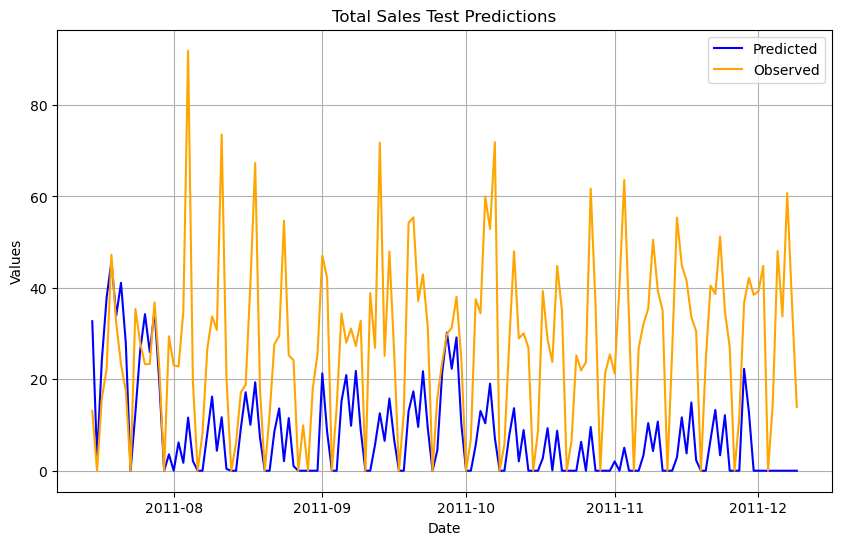

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(pd.to_datetime(test_data['ds']), best_test_forecast['yhat'], label='Predicted', color='blue')
plt.plot(pd.to_datetime(test_data['ds']), test_data['y'], label='Observed', color='orange')
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Total Sales Test Predictions')
plt.legend()
plt.grid(True)
plt.show()

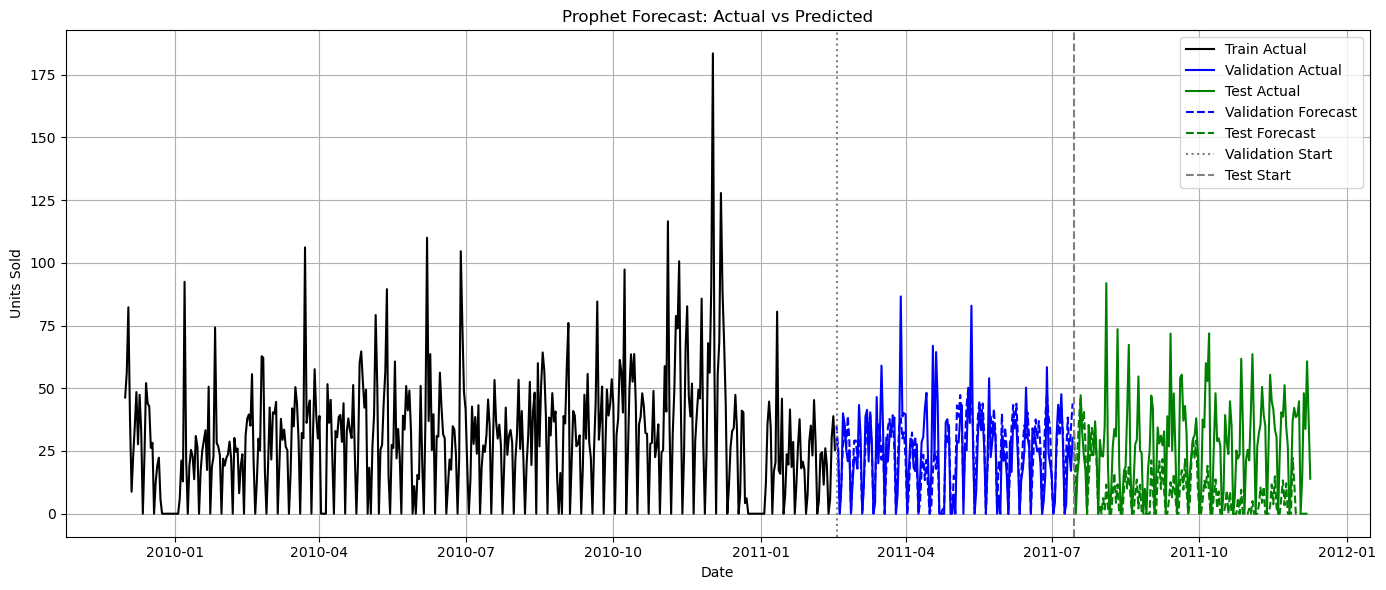

In [34]:
plt.figure(figsize=(14, 6))

plt.plot(train_data['ds'], train_data['y'], label='Train Actual', color='black')
plt.plot(validation_data['ds'], validation_data['y'], label='Validation Actual', color='blue')
plt.plot(test_data['ds'], test_data['y'], label='Test Actual', color='green')

plt.plot(best_validation_forecast['ds'], best_validation_forecast['yhat'], label='Validation Forecast', color='blue', linestyle='--')
plt.plot(best_test_forecast['ds'], best_test_forecast['yhat'], label='Test Forecast', color='green', linestyle='--')

plt.axvline(x=validation_data['ds'].min(), color='gray', linestyle=':', label='Validation Start')
plt.axvline(x=test_data['ds'].min(), color='gray', linestyle='--', label='Test Start')

plt.title('Prophet Forecast: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
